## Import packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import plotly.express as px
import requests
import json
from bs4 import BeautifulSoup
import time

df = pd.read_csv('data.csv')
df = df[df['popularity'] != 0]
df.head()

## Looking at and cleaning the data

In [3]:
df['name'].value_counts()

White Christmas        70
Winter Wonderland      59
Summertime             52
Jingle Bells           52
Silent Night           43
                       ..
Black Dahlia            1
TATI                    1
Sombrita de Cocales     1
Par De Alianzas         1
Poison & Wine           1
Name: name, Length: 109268, dtype: int64

In [4]:
df['primary_artist'] = df['artists'].apply(lambda x: ast.literal_eval(x)[0])
df['title_artist'] = df['name'] + ' ' + df['primary_artist']
df['title_artist_search_term'] = ['%20'.join(search.split(' ')) for search in df['title_artist']]
df['title_artist']

0         Piano Concerto No. 3 in D Minor, Op. 30: III. ...
1                        Clancy Lowered the Boom Dennis Day
2         Gati Bali KHP Kridhamardawa Karaton Ngayogyaka...
3                                    Danny Boy Frank Parker
4                    When Irish Eyes Are Smiling Phil Regan
                                ...                        
170648                                       China Anuel AA
170649                 Halloweenie III: Seven Days Ashnikko
170650                                          AYA MAMAMOO
170651                                      Darkness Eminem
170652                Billetes Azules (with J Balvin) KEVVO
Name: title_artist, Length: 142761, dtype: object

In [5]:
df = df.sort_values(by='popularity', ascending=False)
df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,loudness,mode,name,popularity,release_date,speechiness,tempo,primary_artist,title_artist,title_artist_search_term
19611,0.145,2020,0.4010,"['Bad Bunny', 'Jhay Cortez']",0.731,205090,0.573,1,47EiUVwUp4C9fGccaPuUCS,0.000052,...,-10.059,0,Dakiti,100,2020-10-30,0.0544,109.928,Bad Bunny,Dakiti Bad Bunny,Dakiti%20Bad%20Bunny
19606,0.756,2020,0.2210,"['24kGoldn', 'iann dior']",0.700,140526,0.722,1,3tjFYV6RSFtuktYl3ZtYcq,0.000000,...,-3.558,0,Mood (feat. iann dior),99,2020-07-24,0.0369,90.989,24kGoldn,Mood (feat. iann dior) 24kGoldn,Mood%20(feat.%20iann%20dior)%2024kGoldn
19618,0.737,2020,0.0112,['BTS'],0.746,199054,0.765,0,0t1kP63rueHleOhQkYSXFY,0.000000,...,-4.410,0,Dynamite,97,2020-08-28,0.0993,114.044,BTS,Dynamite BTS,Dynamite%20BTS
19610,0.682,2020,0.4680,['Ariana Grande'],0.737,172325,0.802,1,35mvY5S1H3J2QZyna3TFe0,0.000000,...,-4.771,1,positions,96,2020-10-30,0.0878,144.015,Ariana Grande,positions Ariana Grande,positions%20Ariana%20Grande
19612,0.543,2020,0.6500,['Pop Smoke'],0.709,160000,0.548,1,1tkg4EHVoqnhR6iFEXb60y,0.000002,...,-8.493,1,What You Know Bout Love,96,2020-07-03,0.3530,83.995,Pop Smoke,What You Know Bout Love Pop Smoke,What%20You%20Know%20Bout%20Love%20Pop%20Smoke


## Visualizing popularity

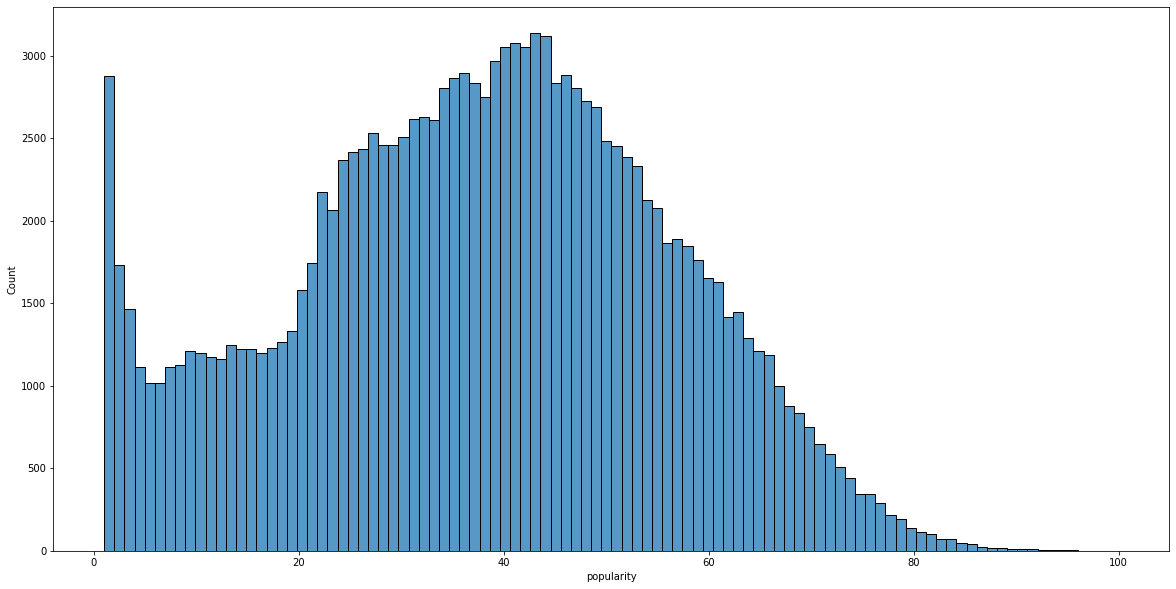

In [106]:
# px.histogram(df, x='popularity')
plt.figure(figsize=(20,10))
sns.histplot(df, x='popularity');

## Modeling popularity as provided by Spotify

In [107]:
df.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo', 'primary_artist', 'title_artist',
       'title_artist_search_term'],
      dtype='object')

In [108]:
from sklearn.model_selection import train_test_split
X = df[['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo']]
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [109]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.3148975766243203

In [110]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train, y_train)
X_test_scaled = ss.transform(X_test)

In [111]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr.score(X_test_scaled, y_test)

0.31489757662432005

In [112]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures()
X_train_exp = pf.fit_transform(X_train, y_train)
X_test_exp = pf.transform(X_test)

In [113]:
lr = LinearRegression()
lr.fit(X_train_exp, y_train)
lr.score(X_test_exp, y_test)

0.3935433110979457

## This data is interesting, but we don't just want to look at the popularity provided by Spotify. It would also be good to bring in some data from other sources - Genius.com will be a great source.

### Genius is a website that provides the backstory behind music lyrics, and the best part is that all of the information is crowdsourced! Passionate fans add the story for the lyrics of their favorite songs, so this will give us a great sense of people who are the most passionate about a given song!

## Get search results from Genius API

In [114]:
get_genius_api_results = False # MARK AS FALSE UNLESS YOU WANT TO MAKE 10k API CALLS

if get_genius_api_results:
    
    print('GETTING API RESULTS - INTERRUPT KERNEL IF THIS IS NOT INTENDED')
    
    # Create a dataframe in which we will pass API results
    df_genius_api = pd.DataFrame(columns=['search_term', 'annotation_count', 'full_title', 'pyongs_count', 'stats_unreviewed_annotations', 'stats_hot', 'song_url', 'primary_artist'])
    
    # Create a function to get data from the Genius API, such as user interaction like views, annotations
    for search_term in df['title_artist_search_term'][0:10000]:
        url = f"https://api.genius.com/search?q={search_term}"
        payload={}
        headers = {
          'Authorization': f'Bearer {token}',
          'Cookie': cookie
        }
        response = requests.request("GET", url, headers=headers, data=payload)
        result_big = json.loads(response.text)['response']['hits']
        if len(result_big) > 0:
            result = result_big[0]['result']
            arr = {'search_term': search_term, 'annotation_count': result['annotation_count'], 'full_title': result['full_title'], 'pyongs_count': result['pyongs_count'], 'stats_unreviewed_annotations': result['stats']['unreviewed_annotations'], 'stats_hot': result['stats']['hot'], 'song_url': result['url'], 'primary_artist': result['primary_artist']['name']}
            df_genius_api = df_genius_api.append(arr, ignore_index=True)
        else:
            arr = {'search_term': search_term, 'annotation_count': 'n/a', 'full_title': 'n/a', 'pyongs_count': 'n/a', 'stats_unreviewed_annotations': 'n/a', 'stats_hot': 'n/a', 'song_url': 'n/a', 'primary_artist': 'n/a'}
            df_genius_api = df_genius_api.append(arr, ignore_index=True)
        time.sleep(.5)
        
    df_genius_api.to_csv(r'genius_api_results.csv')
else:
    print('Reading in df from csv')
    df_genius_api = pd.read_csv('genius_api_results.csv')
print('done')

Reading in df from csv
done


## Webscraping lyrics from Genius.com

In [15]:
def get_lyrics(url):
    try:
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'lxml')
        lyrics = soup.select_one('div[class^="lyrics"]').find('p').getText()
        lyrics = lyrics.replace("\n", "").replace("\'", "")
        return lyrics
    except:
        return 'no lyrics available on Genius'

In [115]:
scrape_genius_for_lyrics = False # MARK AS FALSE UNLESS YOU WANT TO WEBSCRAPE 10k WEBPAGES

if scrape_genius_for_lyrics:
    print('WEBSCRAPING - INTERRUPT KERNEL IF THIS IS NOT INTENDED')
    df_genius_api['song_lyrics_text'] = df_genius_api['song_url'].apply(get_lyrics)
    df_genius_api.to_csv(r'genius_api_and_lyrics.csv')

df_genius = pd.read_csv('genius_api_and_lyrics.csv')

## Merge original Spotify dataframe and Genius data (API and webscraped)

In [116]:
df_merged = pd.merge(df, df_genius, how='inner', left_on='title_artist_search_term', right_on='search_term')
pd.set_option('display.max_columns', None)
df_merged = df_merged[['id', 'full_title', 'name', 'primary_artist_x',  'release_date', 'explicit', 'duration_ms', 'valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key','liveness', 'loudness', 'mode',  'speechiness', 'tempo',  'annotation_count', 'popularity', 'pyongs_count', 'stats_unreviewed_annotations','stats_hot', 'song_url', 'song_lyrics_text']]
# dropping 'primary_artist_y', 'title_artist','title_artist_search_term', 'search_term',  'artists', 'year'
df_all = df_merged.drop_duplicates(subset=['full_title'])
df_all = df_all.reset_index(drop=True)
# df_all

,id,full_title,name,primary_artist_x,release_date,explicit,duration_ms,valence,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,annotation_count,popularity,pyongs_count,stats_unreviewed_annotations,stats_hot,song_url,song_lyrics_text
0,47EiUVwUp4C9fGccaPuUCS,DÁKITI by Bad Bunny & Jhay Cortez,Dakiti,Bad Bunny,2020-10-30,1,205090,0.145,0.4010,0.731,0.573,0.000052,4,0.1130,-10.059,0,0.0544,109.928,1.0,100,46.0,0.0,False,https://genius.com/Bad-bunny-and-jhay-cortez-d...,"[Letra de ""DÁKITI""][Coro: Jhay Cortez]Baby, ya..."
1,3tjFYV6RSFtuktYl3ZtYcq,This Is 24kGoldn by Spotify,Mood (feat. iann dior),24kGoldn,2020-07-24,1,140526,0.756,0.2210,0.700,0.722,0.000000,7,0.2720,-3.558,0,0.0369,90.989,1.0,99,NaN,1.0,False,https://genius.com/Spotify-this-is-24kgoldn-ly...,1. 24kGoldn- Mood (feat. iann dior)2. 24kGoldn...
2,0t1kP63rueHleOhQkYSXFY,Dynamite by BTS (방탄소년단),Dynamite,BTS,2020-08-28,0,199054,0.737,0.0112,0.746,0.765,0.000000,6,0.0936,-4.410,0,0.0993,114.044,6.0,97,228.0,0.0,False,https://genius.com/Bts-dynamite-lyrics,"[Intro: Jungkook]Cause I, I, Im in the stars t..."
3,35mvY5S1H3J2QZyna3TFe0,​positions by Ariana Grande,positions,Ariana Grande,2020-10-30,1,172325,0.682,0.4680,0.737,0.802,0.000000,0,0.0931,-4.771,1,0.0878,144.015,9.0,96,176.0,0.0,False,https://genius.com/Ariana-grande-positions-lyrics,[Verse 1]Heaven sent you to meIm just hopin’ I...
4,1tkg4EHVoqnhR6iFEXb60y,What You Know Bout Love by Pop Smoke,What You Know Bout Love,Pop Smoke,2020-07-03,1,160000,0.543,0.6500,0.709,0.548,0.000002,10,0.1330,-8.493,1,0.3530,83.995,1.0,96,35.0,0.0,False,https://genius.com/Pop-smoke-what-you-know-bou...,[Intro]Uh[Verse 1]Shawty go jogging every morn...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8642,3Q0U0QJEGjA2rZPoGVVaWY,Pack Lite by Queen Naija,Pack Lite,Queen Naija,2020-07-24,1,176956,0.405,0.2370,0.496,0.776,0.000000,7,0.1260,-5.088,0,0.2210,139.284,1.0,65,1.0,1.0,False,https://genius.com/Queen-naija-pack-lite-lyrics,"[Verse 1]See, I dont got the time or the patie..."
8643,4jikVslCvDrDysc3p4tFHM,Vendedora De Caricias by Panteón Rococó,Vendedora de Caricias,Panteon Rococo,2007-05-22,0,225173,0.902,0.0879,0.936,0.675,0.000000,6,0.0854,-6.076,0,0.0475,125.024,1.0,65,NaN,0.0,False,https://genius.com/Panteon-rococo-vendedora-de...,Finge que te importo un pocoQue me pones atenc...
8644,6uQe7SVjdDlRqDRAi0qnKg,Talking by Elderbrook,Talking,Elderbrook,2017-09-01,0,202845,0.415,0.0944,0.897,0.569,0.644000,8,0.1080,-9.822,1,0.0529,114.981,3.0,65,NaN,3.0,False,https://genius.com/Elderbrook-talking-lyrics,[Verse 1]I got a friend but they dont like meT...
8645,6Dq2LzijkY9WNPwBGDah4L,Didn't I by Darondo,Didn't I,Darondo,2005-01-24,0,209160,0.638,0.8970,0.463,0.382,0.263000,5,0.1080,-11.682,1,0.0278,74.573,1.0,65,3.0,1.0,False,https://genius.com/Darondo-didnt-i-lyrics,[Intro]Do-do-do-do-do-oo-oo-oo-ooBah-da-da-da-...


## Looking at data in merged tables

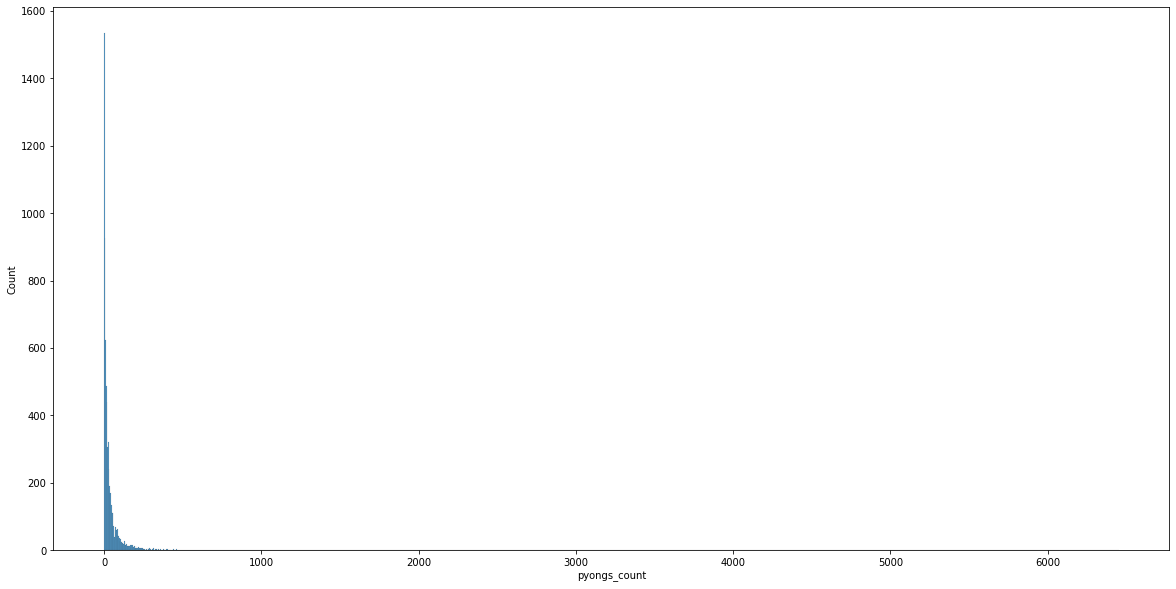

In [120]:
plt.figure(figsize=(20,10))
sns.histplot(df_all, x='pyongs_count');

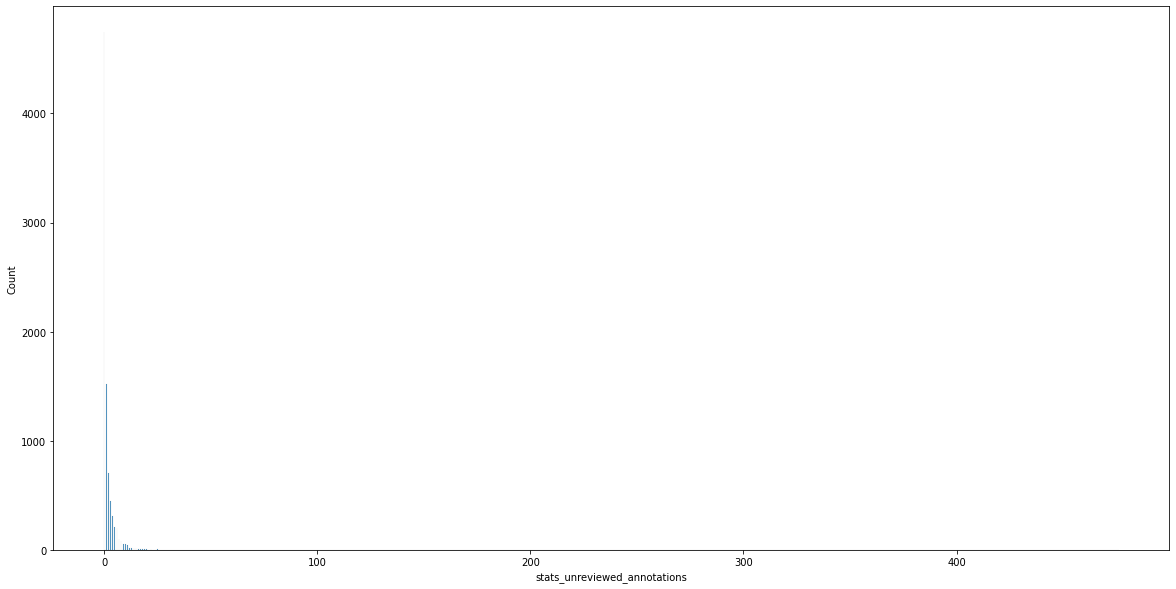

In [121]:
plt.figure(figsize=(20,10))
sns.histplot(df_all, x='stats_unreviewed_annotations');

## Get most hummed songs list

In [118]:
get_most_hummed_songs = False # MARK AS FALSE UNLESS YOU WANT TO WEBSCRAPE BILLBOARD.COM

if get_most_hummed_songs:
    from selenium import webdriver
    DRIVER_PATH = '/usr/local/bin/chromedriver'
    driver = webdriver.Chrome(executable_path=DRIVER_PATH)
    driver.get('https://www.billboard.com/charts/year-end/top-hummed')
    table = driver.find_element_by_xpath('//html/body/main/div/div/div[4]/div/ol')
    table_text = table.text.split('\n')

    rank = []
    title = []
    artist = []

    for num in range(0, len(table_text), 3):
        rank.append(table_text[num])
        title.append(table_text[num+1])
        artist.append(table_text[num+2])

    df_hummed_list = pd.DataFrame({'rank': rank, 'title': title, 'artist': artist}).set_index('rank')
    df_hummed_list.to_csv(r'songs_hummed.csv')
else:
    df_hummed_list = pd.read_csv('songs_hummed.csv')

In [119]:
df_hummed = pd.merge(df_all, df_hummed, how='inner', left_on='name', right_on='title').drop_duplicates()
# df_hummed